In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from langdetect import detect_langs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from nltk import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
import spacy
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('ratebeer.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,name,id,brewerID,abv,style,appearance,aroma,palate,taste,overall,time,profileName,reviewtext
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,5-Apr,10-Jun,5-Mar,10-Jun,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,5-Apr,10-Jun,5-Apr,10-Jul,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,5-Apr,10-May,5-Mar,10-Jun,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,5-Feb,10-Apr,5-Feb,10-Apr,20-Aug,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,5-Feb,10-Apr,5-Feb,10-Apr,20-Aug,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."


In [4]:
df_1 = df.sample(frac=0.25)

In [5]:
df_1.shape

(262144, 13)

In [6]:
df_2 = df.sample(frac=0.05)
df_2.shape

(52429, 13)

In [7]:
df_3 = df_2[['name', 'reviewtext']]

In [8]:
df_3.head()

,name,reviewtext
537101,Chapeau Banana,"How to make chapeau banana:\t\tTake a blender,..."
64320,Lagunitas Sucks Holiday Ale,On tap at the Map Room for their 19th annivers...
92414,Abita SOS &#40;Save Our Shore&#41;,Bottle Yellow to light golden ale with a mid-s...
720649,Terminal Gravity IPA,"UPDATED: FEB 2, 2005 (12 oz bottles: Obtained ..."
624659,Ayinger Celebrator Doppelbock,ambrato carico quasi scura buona schiuma discr...


In [9]:
df_3 = df_3.rename(columns={'reviewtext': 'review'})

In [10]:
# length of the reviews
length_reviews = df_3.review.str.len()

In [11]:
df_3['length'] = length_reviews

In [12]:
df_3.head()

,name,review,length
537101,Chapeau Banana,"How to make chapeau banana:\t\tTake a blender,...",291.0
64320,Lagunitas Sucks Holiday Ale,On tap at the Map Room for their 19th annivers...,1039.0
92414,Abita SOS &#40;Save Our Shore&#41;,Bottle Yellow to light golden ale with a mid-s...,286.0
720649,Terminal Gravity IPA,"UPDATED: FEB 2, 2005 (12 oz bottles: Obtained ...",2489.0
624659,Ayinger Celebrator Doppelbock,ambrato carico quasi scura buona schiuma discr...,354.0


In [13]:
avg_length = df_3.length.mean()
print('Average Length: {}'.format(avg_length))

Average Length: 309.88311465077635


In [14]:
longest_review = df_3['length'].max()
shortest_review = df_3['length'].min()
print('Longest Review: {}'.format(longest_review))
print('Shortest Review: {}'.format(shortest_review))

Longest Review: 3358.0
Shortest Review: 1.0


In [15]:
df_4 = df_3.sort_values(by=['length'], ascending=False)
df_4.head()

,name,review,length
234298,StoneWall Ale,(Draft: Stone Wall Party) Jason is manning the...,3358.0
692095,Terrapin Rye Squared,"UPDATED: APR 21, 2006 Long awaited arrival at ...",3266.0
1022431,North Coast Old Stock Cellar Reserve Bourbon B...,"Pours with a quickly dissipating, initially on...",3140.0
465364,AleSmith Weizenbock,"UPDATED: SEP 23, 2005 (750 ml bottle: Stuffed ...",3076.0
123969,Harveys Imperial Stout,"UPDATED: AUG 20, 2007 2000 bottle consumed Feb...",2879.0


In [16]:
# Detect the language of the review

In [17]:
reviews = df_4.sample(frac=0.50)
reviews.head()

,name,review,length
916034,Molson India Beer,341ml bottle from the NLC in St. Johns. Only s...,292.0
622022,Ayinger Jahrhundert,Very pale golden - lasting foam - floral aroma...,295.0
914354,Molson Canadian,Standard macro offering aside from a less fain...,315.0
860343,Spanish Peaks Black Dog Ale,Not the worst beer I have had but not my favor...,240.0
221726,Allagash Dubbel Reserve,"Yellowish head. Strong alcohol taste, but enj...",138.0


In [18]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26214 entries, 916034 to 978590
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    26214 non-null  object 
 1   review  26178 non-null  object 
 2   length  26178 non-null  float64
dtypes: float64(1), object(2)
memory usage: 819.2+ KB


In [19]:
review = str(reviews.review)

In [20]:
languages = []

for r in range(len(reviews)):
    languages.append(detect_langs(reviews.iloc[r, 0]))

In [21]:
languages = [str(lang).split(':')[0][1] for lang in languages]

In [22]:
reviews['lang'] = languages

In [23]:
reviews.head()

,name,review,length,lang
916034,Molson India Beer,341ml bottle from the NLC in St. Johns. Only s...,292.0,e
622022,Ayinger Jahrhundert,Very pale golden - lasting foam - floral aroma...,295.0,d
914354,Molson Canadian,Standard macro offering aside from a less fain...,315.0,e
860343,Spanish Peaks Black Dog Ale,Not the worst beer I have had but not my favor...,240.0,e
221726,Allagash Dubbel Reserve,"Yellowish head. Strong alcohol taste, but enj...",138.0,e


In [24]:
# Removing non english reviews and Keeping only reviews in english

reviews_e = reviews.loc[lambda reviews: reviews['lang'] == 'e']
reviews_e

,name,review,length,lang
916034,Molson India Beer,341ml bottle from the NLC in St. Johns. Only s...,292.0,e
914354,Molson Canadian,Standard macro offering aside from a less fain...,315.0,e
860343,Spanish Peaks Black Dog Ale,Not the worst beer I have had but not my favor...,240.0,e
221726,Allagash Dubbel Reserve,"Yellowish head. Strong alcohol taste, but enj...",138.0,e
41634,Scotch Irish John By Imperial Stout,Black in color with a medium sized tan head. A...,152.0,e
...,...,...,...,...
221165,Allagash Tripel Reserve,(Bottle). Citrusy aroma. Hazy amber color. ...,224.0,e
594874,Cottage The Panther,14th July 2010. Market Porter. Clear brown bee...,235.0,e
346215,Pizza Port Hop Suey Double IPA,on tap at pizza port carlsbad. 100th rating fo...,618.0,e
1011033,North Coast Red Seal Ale,"Delicious aroma, one of the best scents Ive ev...",179.0,e


In [25]:
avg_length_e = reviews_e.length.mean()
longest_review_e = reviews_e['length'].max()
shortest_review_e = reviews_e['length'].min()
print('Average Length: {}'.format(avg_length_e))
print('Longest Review: {}'.format(longest_review_e))
print('Shortest Review: {}'.format(shortest_review_e))

Average Length: 322.58956671696484
Longest Review: 3266.0
Shortest Review: 1.0


In [26]:
reviews_e['review'] = reviews_e['review'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
reviews_e['sentiment'] = round(reviews_e['review'].apply(lambda x: TextBlob(x).sentiment[0]),2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
reviews_e

,name,review,length,lang,sentiment
916034,Molson India Beer,341ml bottle from the NLC in St. Johns. Only s...,292.0,e,-0.29
914354,Molson Canadian,Standard macro offering aside from a less fain...,315.0,e,-0.06
860343,Spanish Peaks Black Dog Ale,Not the worst beer I have had but not my favor...,240.0,e,-0.17
221726,Allagash Dubbel Reserve,"Yellowish head. Strong alcohol taste, but enj...",138.0,e,0.38
41634,Scotch Irish John By Imperial Stout,Black in color with a medium sized tan head. A...,152.0,e,-0.04
...,...,...,...,...,...
221165,Allagash Tripel Reserve,(Bottle). Citrusy aroma. Hazy amber color. ...,224.0,e,0.35
594874,Cottage The Panther,14th July 2010. Market Porter. Clear brown bee...,235.0,e,0.06
346215,Pizza Port Hop Suey Double IPA,on tap at pizza port carlsbad. 100th rating fo...,618.0,e,0.16
1011033,North Coast Red Seal Ale,"Delicious aroma, one of the best scents Ive ev...",179.0,e,0.57


In [29]:
reviews_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13936 entries, 916034 to 873861
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       13936 non-null  object 
 1   review     13936 non-null  object 
 2   length     13917 non-null  float64
 3   lang       13936 non-null  object 
 4   sentiment  13936 non-null  float64
dtypes: float64(2), object(3)
memory usage: 653.2+ KB


In [30]:
reviews_1 = reviews_e

In [31]:
reviews_1.reset_index(drop=True, inplace=True)

In [32]:
reviews_1.head()

,name,review,length,lang,sentiment
0,Molson India Beer,341ml bottle from the NLC in St. Johns. Only s...,292.0,e,-0.29
1,Molson Canadian,Standard macro offering aside from a less fain...,315.0,e,-0.06
2,Spanish Peaks Black Dog Ale,Not the worst beer I have had but not my favor...,240.0,e,-0.17
3,Allagash Dubbel Reserve,"Yellowish head. Strong alcohol taste, but enj...",138.0,e,0.38
4,Scotch Irish John By Imperial Stout,Black in color with a medium sized tan head. A...,152.0,e,-0.04


In [33]:
reviews_1.iloc[0]

name                                         Molson India Beer
review       341ml bottle from the NLC in St. Johns. Only s...
length                                                     292
lang                                                         e
sentiment                                                -0.29
Name: 0, dtype: object

In [34]:
sentiment_1 = []

for i in range(len(reviews_1)):
    if reviews_1.sentiment[i] >= 0.10:
        sentiment_1.append(2)
    elif reviews_1.sentiment[i] >= -0.10:
        sentiment_1.append(0)
    else:
        sentiment_1.append(1)

In [35]:
reviews_1['sentiment_1'] = sentiment_1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
reviews_1

,name,review,length,lang,sentiment,sentiment_1
0,Molson India Beer,341ml bottle from the NLC in St. Johns. Only s...,292.0,e,-0.29,1
1,Molson Canadian,Standard macro offering aside from a less fain...,315.0,e,-0.06,0
2,Spanish Peaks Black Dog Ale,Not the worst beer I have had but not my favor...,240.0,e,-0.17,1
3,Allagash Dubbel Reserve,"Yellowish head. Strong alcohol taste, but enj...",138.0,e,0.38,2
4,Scotch Irish John By Imperial Stout,Black in color with a medium sized tan head. A...,152.0,e,-0.04,0
...,...,...,...,...,...,...
13931,Allagash Tripel Reserve,(Bottle). Citrusy aroma. Hazy amber color. ...,224.0,e,0.35,2
13932,Cottage The Panther,14th July 2010. Market Porter. Clear brown bee...,235.0,e,0.06,0
13933,Pizza Port Hop Suey Double IPA,on tap at pizza port carlsbad. 100th rating fo...,618.0,e,0.16,2
13934,North Coast Red Seal Ale,"Delicious aroma, one of the best scents Ive ev...",179.0,e,0.57,2


In [37]:
reviews_1['sentiment_1'].value_counts()

2    9111
0    4136
1     689
Name: sentiment_1, dtype: int64

In [109]:
reviews_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13936 entries, 0 to 13935
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         13936 non-null  object 
 1   review       13936 non-null  object 
 2   length       13917 non-null  float64
 3   lang         13936 non-null  object 
 4   sentiment    13936 non-null  float64
 5   sentiment_1  13936 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 653.4+ KB


In [38]:
reviews_1.sentiment_1[0]

1

In [39]:
range(len(reviews_1.sentiment_1))

range(0, 13936)

In [112]:
positive = []
negative = []
neutral = []

for i in range(len(reviews_1.sentiment_1)-1):
    if reviews_1.sentiment_1[i] == 2:
        positive.append(reviews_1.review[i])
    elif reviews_1.sentiment_1[i] == 1:
        negative.append(reviews_1.review[i])
    else:
        neutral.append(reviews_1.review[i])
   

In [110]:
reviews_1.review[13935]

'bottle beers of europe (and africa of course), malty aroma, pale, clear, white foam, normal colour,medium sweetness, lightly bitter, drinkable,medium body, slick feel, smoothylong finish, average carbonation, not bad lager from Etiopia'

In [107]:
len(review)

702

In [103]:
len(reviews_1.sentiment_1)-1

13935

In [115]:
print(len(positive))
print(len(negative))
print(len(neutral))

9111
689
4135


In [116]:
positive_string = str(positive)
negative_string = str(negative)
neutral_string = str(neutral)

In [45]:
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

In [113]:
my_stop_words = ENGLISH_STOP_WORDS.union(['Aroma', 'head', 'is'])

In [117]:
positive_cloud = WordCloud(stopwords = my_stop_words).generate(positive_string)

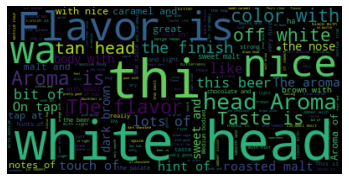

In [118]:
plt.imshow(positive_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

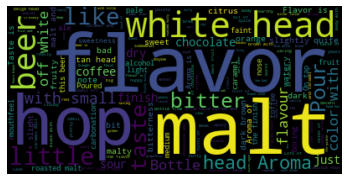

In [119]:
negative_cloud = WordCloud(stopwords=my_stop_words).generate(negative_string)
plt.imshow(negative_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

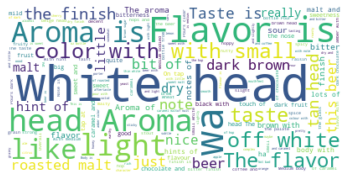

In [120]:
neutral_cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(neutral_string)
plt.imshow(neutral_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [140]:
# Tokenizing words

In [45]:
word_tokens = [word_tokenize(review) for review in reviews_1.review]

In [46]:
cleaned_tokens = [[word for word in items if word.isalpha()]for items in word_tokens]

In [47]:
print(len(word_tokens))
print(len(cleaned_tokens))

13936
13936


In [48]:
print(word_tokens[0])

['341ml', 'bottle', 'from', 'the', 'NLC', 'in', 'St.', 'Johns', '.', 'Only', 'sold', 'in', 'NFLD', '.', 'Not', 'over-carbonated', 'in', 'the', 'artificial', 'sense', 'of', 'having', 'that', 'terrible', 'acidic', 'nastiness', ',', 'but', 'this', 'beer', 'seemed', 'to', 'be', 'all', 'effervesance', '.', 'Is', 'bubbles', 'a', 'taste', '?', 'This', 'stuff', 'just', 'seemed', 'to', 'disappear', 'in', 'my', 'mouth', 'which', 'make', 'for', 'some', 'easy', 'drinking', '.']


In [49]:
print(cleaned_tokens[0])

['bottle', 'from', 'the', 'NLC', 'in', 'Johns', 'Only', 'sold', 'in', 'NFLD', 'Not', 'in', 'the', 'artificial', 'sense', 'of', 'having', 'that', 'terrible', 'acidic', 'nastiness', 'but', 'this', 'beer', 'seemed', 'to', 'be', 'all', 'effervesance', 'Is', 'bubbles', 'a', 'taste', 'This', 'stuff', 'just', 'seemed', 'to', 'disappear', 'in', 'my', 'mouth', 'which', 'make', 'for', 'some', 'easy', 'drinking']


In [50]:
print(len(word_tokens[0]))
print(len(cleaned_tokens[0]))

57
48


In [51]:
# Stemming & Lemmatizing

In [52]:
lemmatizer = WordNetLemmatizer()

In [53]:
lem_tokens = [[lemmatizer.lemmatize(word) for word in token]for token in cleaned_tokens]

In [54]:
print(len(lem_tokens[0]))

48


In [55]:
porter = PorterStemmer()

In [56]:
stemmed_tokens = [[porter.stem(word) for word in token]for token in cleaned_tokens]

In [57]:
print(len(stemmed_tokens[0]))

48


In [187]:
# nlp = spacy.load('en_core_web_sm')

In [196]:
# review_string = str(reviews_1.review)
# print(review_string)

In [189]:
# doc = nlp(review_string)
# len(doc)

In [190]:
# lemmas = [token.lemma_ for token in doc]

In [191]:
# len(lemmas[0])

In [192]:
# a_lemmas = [lemma for lemma in lemmas if lemma.isalpha()]

In [193]:
# print(' '.join(a_lemmas))

In [194]:
# len(a_lemmas[0])

In [167]:
reviews_1.review

0        341ml bottle from the NLC in St. Johns. Only s...
1        Standard macro offering aside from a less fain...
2        Not the worst beer I have had but not my favor...
3        Yellowish head.  Strong alcohol taste, but enj...
4        Black in color with a medium sized tan head. A...
                               ...                        
13931    (Bottle).  Citrusy aroma.  Hazy amber color.  ...
13932    14th July 2010. Market Porter. Clear brown bee...
13933    on tap at pizza port carlsbad. 100th rating fo...
13934    Delicious aroma, one of the best scents Ive ev...
13935    bottle beers of europe (and africa of course),...
Name: review, Length: 13936, dtype: object

In [58]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')

In [59]:
vectorizer.fit(reviews_1.review)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [60]:
review_text = vectorizer.transform(reviews_1.review)

In [61]:
review_df = pd.DataFrame(review_text.toarray(), columns=vectorizer.get_feature_names())

In [62]:
review_df

,00,01,02,03,04,05,06,07,07 pours,08,...,youre,youve,yum,yummy,zero,zero head,zest,zest light,zesty,zing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.279425,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
review_df['sentiment'] = reviews_1['sentiment_1']

In [64]:
review_df['name'] = reviews_1['name']

In [65]:
review_df.head()

,00,01,02,03,04,05,06,07,07 pours,08,...,yum,yummy,zero,zero head,zest,zest light,zesty,zing,sentiment,name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Molson India Beer
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Molson Canadian
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Spanish Peaks Black Dog Ale
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Allagash Dubbel Reserve
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Scotch Irish John By Imperial Stout


In [95]:
y = review_df['sentiment']

In [96]:
X = review_df.drop('sentiment', axis=1)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [82]:
lr = LogisticRegression()

In [83]:
lr.fit(X_train.drop('name', axis=1), y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
y_pred = lr.predict(X_test.drop('name', axis=1))

In [85]:
print("Accuracy_score: \n {}".format(accuracy_score(y_test, y_pred)))

Accuracy_score: 
 0.7840746054519369


In [86]:
print("Confusion Matrix: \n {}".format(confusion_matrix(y_test, y_pred)))

Confusion Matrix: 
 [[ 463    1  363]
 [ 107    3   28]
 [ 103    0 1720]]


In [87]:
proba = lr.predict_proba(X_test.drop('name', axis=1))

In [88]:
proba

array([[0.02165314, 0.00629322, 0.97205364],
       [0.56851365, 0.17203402, 0.25945233],
       [0.6206565 , 0.02046829, 0.35887521],
       ...,
       [0.0111584 , 0.00291538, 0.98592622],
       [0.0374682 , 0.00819061, 0.95434119],
       [0.58746669, 0.05868531, 0.353848  ]])

In [89]:
y_pred

array([2, 0, 0, ..., 2, 2, 0])

In [121]:
X_test.head()

,00,01,02,03,04,05,06,07,07 pours,08,...,youve,yum,yummy,zero,zero head,zest,zest light,zesty,zing,name
7402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Grand Ridge Gippsland Gold
3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Titanic Deckchair
10353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Red Duck Limited Release Ugly Duckling Braggot
3962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Marstons Pure Blonde
3341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shorts The Curl Imperial Pilsner


In [126]:
X_test.reset_index(drop=True, inplace=True)

In [127]:
X_test

,00,01,02,03,04,05,06,07,07 pours,08,...,youve,yum,yummy,zero,zero head,zest,zest light,zesty,zing,name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Grand Ridge Gippsland Gold
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Titanic Deckchair
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Red Duck Limited Release Ugly Duckling Braggot
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Marstons Pure Blonde
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shorts The Curl Imperial Pilsner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AleSmith Decadence 2010
2784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Archers Cupids Arrow
2785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Westmalle Tripel
2786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AleSmith Kopi Luwak Speedway Stout


In [128]:
pred_df = pd.DataFrame(X_test['name'], y_pred)
pred_df

,name
2,Red Duck Limited Release Ugly Duckling Braggot
0,Grand Ridge Gippsland Gold
0,Grand Ridge Gippsland Gold
2,Red Duck Limited Release Ugly Duckling Braggot
0,Grand Ridge Gippsland Gold
...,...
2,Red Duck Limited Release Ugly Duckling Braggot
0,Grand Ridge Gippsland Gold
2,Red Duck Limited Release Ugly Duckling Braggot
2,Red Duck Limited Release Ugly Duckling Braggot


In [129]:
pred_df.to_csv('prediction.csv')

In [166]:
#  Increase the features to 50000

In [153]:
vectorizer_1 = TfidfVectorizer(ngram_range=(1,2), max_features=50000, stop_words='english')
vectorizer_1.fit(reviews_1.review)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=50000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [154]:
review_text_1 = vectorizer_1.transform(reviews_1.review)
review_df_1 = pd.DataFrame(review_text_1.toarray(), columns=vectorizer_1.get_feature_names())

In [155]:
review_df_1.head()

,00,00 abv,01,01 02,01 06,01 07,01 08,01 09,01 12,01 17,...,zima,zing,zingy,zinister,zip,zippy,zippy carbonation,zis,zum,zum ende
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
review_df_1['sentiment'] = reviews_1['sentiment_1']
review_df_1.head()

,00,00 abv,01,01 02,01 06,01 07,01 08,01 09,01 12,01 17,...,zing,zingy,zinister,zip,zippy,zippy carbonation,zis,zum,zum ende,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [161]:
y_1 = review_df_1['sentiment']
X_1 = review_df_1.drop('sentiment', axis=1)

In [162]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42, stratify=y_1)
lr_1 = LogisticRegression()
lr_1.fit(X_train_1, y_train_1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [163]:
y_predict = lr_1.predict(X_test_1)

In [164]:
print("Accuracy_score: \n {}".format(accuracy_score(y_test_1, y_predict)))

Accuracy_score: 
 0.7669200144770177


In [167]:
# Random forest with 10000 features


In [153]:
rf = RandomForestClassifier()
rf.fit(X_train.drop('name', axis=1), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [155]:
pred_y = rf.predict(X_test.drop('name', axis=1))
print("Accuracy_score: \n {}".format(accuracy_score(y_test, pred_y)))

Accuracy_score: 
 0.7159253945480631


In [130]:
melissa_1 = "Fruity aroma on the nose which made me think it was going to be a fruity tasting beer but in actuality it was more nutty in flavor. Medium bodied but smooth"

In [135]:
melissa_2 = "I don't typically like stouts but decided to try this one anyways. The head was too thick for my liking but once I tasted the beer it was not at all bitter like I think most stouts are"

In [132]:
melissa_3= "Pils are my favorite beer so I'm sorry to say that this one just didn't cut it for me. It left an aftertaste that I just didn't like. It was light as it should be, I just didn't care for the flavor"

In [137]:
melissa_df = pd.DataFrame([melissa_1, melissa_2, melissa_3])

In [146]:
m_df = melissa_df.rename(columns={0:'review_m'})
m_df

,review_m
0,Fruity aroma on the nose which made me think i...
1,I don't typically like stouts but decided to t...
2,Pils are my favorite beer so I'm sorry to say ...


In [157]:
vectorizer_m = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
vectorizer_m.fit(m_df.review_m)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [166]:
m_df_transformed = vectorizer_m.transform(m_df['review_m'])
df_m = pd.DataFrame(m_df_transformed.toarray(), columns = vectorizer_m.get_feature_names())
df_m

,actuality,actuality nutty,aftertaste,aftertaste just,anyways,anyways head,aroma,aroma nose,beer,beer actuality,...,tasted beer,tasting,tasting beer,think,think going,think stouts,try,try anyways,typically,typically like
0,0.190673,0.190673,0.000000,0.000000,0.000000,0.000000,0.190673,0.190673,0.112615,0.190673,...,0.000000,0.190673,0.190673,0.145012,0.190673,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.181846,0.181846,0.000000,0.000000,0.107401,0.000000,...,0.181846,0.000000,0.000000,0.138298,0.000000,0.181846,0.181846,0.181846,0.181846,0.181846
2,0.000000,0.000000,0.139339,0.139339,0.000000,0.000000,0.000000,0.000000,0.082296,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [164]:
rf.predict(df_m)

ValueError: Number of features of the model must match the input. Model n_features is 10000 and input n_features is 77 